## look at encoding-decoding with stim2 nPRF fit

--> debugged: fit_glm_denoise_stim2 was taking wrong slices of result images --> took stim1-event betas! (that is why the observations now but the end of this script)



In [1]:
import os.path as op
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#bids_folder = '/shares/zne.uzh/mrenke/ds-dnumrisk'
bids_folder = '/mnt_03/ds-dnumrisk'
subjects = [int(f[4:]) for f in os.listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]


In [2]:
from numrisk.utils.data import get_data_magjduge

df_behav = get_data_magjduge(bids_folder=bids_folder)
df_behav['log(n2)'] = np.log(df_behav['n2'] )

df_behav.head()

number of subjects found: 66


rt    n1    n2  choice  chose_n2      frac  \
subject run trial_nr                                                     
21      1   1         2.557155  14.0  10.0    True      True  0.714286   
            2         1.222190   5.0   3.0   False     False  0.600000   
            3         1.538609   5.0   5.0    True      True  1.000000   
            4         1.938757   7.0   5.0   False     False  0.714286   
            5         1.488353   5.0   3.0   False     False  0.600000   

                      log(n2/n1)   log(n1)  group   log(n2)  
subject run trial_nr                                         
21      1   1          -0.336472  2.639057      0  2.302585  
            2          -0.510826  1.609438      0  1.098612  
            3           0.000000  1.609438      0  1.609438  
            4          -0.336472  1.945910      0  1.609438  
            5          -0.510826  1.609438      0  1.098612

In [3]:
from utils import get_decoding_info
n_stim = 2

pred_stim2 = []
for sub in subjects:
    pred_stim2.append(get_decoding_info(sub,n_stim=n_stim, bids_folder=bids_folder))

pred_stim2 = pd.concat(pred_stim2)

import pingouin as pg
r = pred_stim2.join(df_behav, how='inner').groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n{n_stim})']))
r_stim2 = r.groupby(['subject','group'])['r'].mean()
print(len(r_stim2)) # 46

problems with: /mnt_03/ds-dnumrisk/derivatives/decoded_pdfs_stim2.volume.cv_vselect.denoise/sub-21/func/sub-21_ses-1_mask-NPC_R_space-T1w_pars.tsv
problems with: /mnt_03/ds-dnumrisk/derivatives/decoded_pdfs_stim2.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv
64


/tmp/ipykernel_3251074/3145652668.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = pred_stim2.join(df_behav, how='inner').groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n{n_stim})']))


In [4]:
n_stim = 1
pred_stim1 = []
for sub in subjects:
    pred_stim1.append(get_decoding_info(sub,n_stim=n_stim, bids_folder=bids_folder))
pred_stim1 = pd.concat(pred_stim1)

r = pred_stim1.join(df_behav, how='inner').groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n{n_stim})']))
r_stim1 = r.groupby(['subject','group'])['r'].mean()

problems with: /mnt_03/ds-dnumrisk/derivatives/decoded_pdfs_stim1.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv


/tmp/ipykernel_3251074/276630041.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = pred_stim1.join(df_behav, how='inner').groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n{n_stim})']))


r_stim1    0.174557
r_stim2    0.051651
dtype: float64


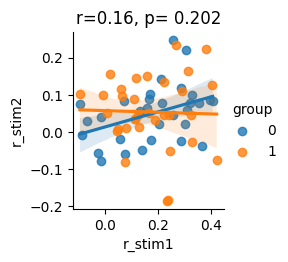

In [5]:
Rs = pd.DataFrame({'r_stim1': r_stim1, 'r_stim2': r_stim2})

cor = pg.corr(Rs['r_stim1'], Rs['r_stim2'])
r_ = np.round(cor.iloc[0]['r'], 2)
p = np.round(cor.iloc[0]['p-val'], 3)

fig = sns.lmplot(x='r_stim1', y='r_stim2', data=Rs.reset_index(),hue='group', height=2.5) # 
fig.set(title=f'r={r_}, p= {p}') 
print(Rs.mean(axis=0))

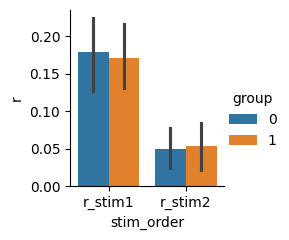

In [6]:
Rs_ = pd.DataFrame(Rs.stack(),columns=['r']).rename_axis(['subject', 'group', 'stim_order'])

sns.catplot(x='stim_order', y='r', data=Rs_.reset_index(), hue='group',height=2.5,kind='bar') #

In [59]:
np.where(Rs['r_stim2'] == Rs['r_stim2'].max())

(array([17]),)

In [62]:
Rs.iloc[17]

r_stim1    0.255839
r_stim2    0.247224
Name: (19, 0), dtype: float64

/tmp/ipykernel_3251074/4011891504.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = pd.DataFrame(df.stack().stack(), columns=['r'])


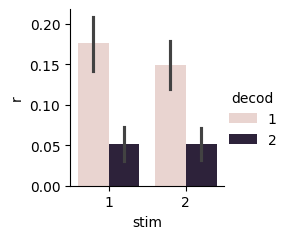

In [55]:
import itertools

predictions = (
    pred_stim2.rename(columns={'E': 'E_n2'})
    .join(pred_stim1.rename(columns={'E': 'E_n1'})['E_n1'])
    .droplevel([1, 2, 3], axis=0)
    .drop(columns=['sd'])
    .join(df_behav[['n1', 'n2', 'log(n1)', 'log(n2)']])
)

cors, pvals = [], []
for n_stim, n_decod in itertools.product([1, 2], repeat=2):
    r = predictions.groupby('subject').apply(lambda d: pg.corr(d[f'E_n{n_decod}'], d[f'log(n{n_stim})']))
    cors.append(r['r'].droplevel(1))
    pvals.append(r['p-val'].droplevel(1))

df = pd.DataFrame(cors, index=pd.MultiIndex.from_product([[1, 2], [1, 2]], names=['stim', 'decod']), columns=subjects).T
df.index.name = 'subject'
df.sort_index(inplace=True)
df = pd.DataFrame(df.stack().stack(), columns=['r'])

# Plotting
sns.catplot(x='stim', y='r', data=df.reset_index(), hue='decod', height=2.5, kind='bar')

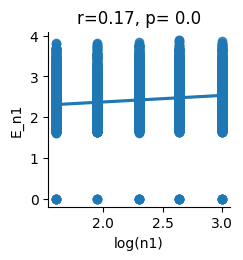

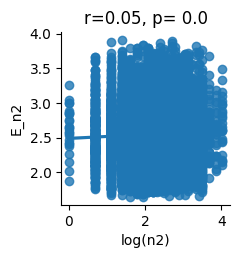

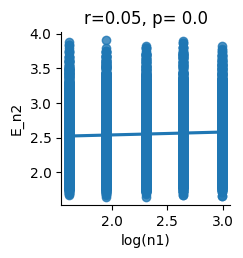

In [10]:
for n in [1,2]:
    x_var = f'log(n{n})'
    y_var = f'E_n{n}'
    cor = pg.corr(predictions[x_var], predictions[y_var])
    r_ = np.round(cor.iloc[0]['r'], 2)
    p = np.round(cor.iloc[0]['p-val'], 5)

    fig = sns.lmplot(x=x_var, y=y_var, data=predictions, height=2.5) # hue='group',
    fig.set(title=f'r={r_}, p= {p}') 

x_var = f'log(n1)'
y_var = f'E_n2'
cor = pg.corr(predictions[x_var], predictions[y_var])
r_ = np.round(cor.iloc[0]['r'], 2)
p = np.round(cor.iloc[0]['p-val'], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=predictions, height=2.5) # hue='group',
fig.set(title=f'r={r_}, p= {p}') 

In [8]:

sns.lmplot(x='E_n1', y='log(n1)', data=predictions, height=2.5)


NameError: name 'predictions' is not defined

### OlD

In [5]:
# save
fn = op.join(bids_folder,'add_tables','decoded-stim2_E.csv')
pred_stim2.reset_index()[['subject','trial_nr','E','sd']].to_csv(fn)

In [15]:
# correlate predicted from stim2 with num from stim1
r_21 = pred_stim2.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n1)']))
r_21 = r_21.groupby(['subject','group'])['r'].mean()

/sctmp/mrenke/ipykernel_1743183/758094809.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_21 = pred_stim2.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n1)']))


In [17]:
n_stim = 1

pred_stim1 = []
for sub in subjects:
    pred_stim1.append(get_decoding_info(sub,n_stim=n_stim, bids_folder=bids_folder))

pred_stim1 = pd.concat(pred_stim1).join(df, how='inner')
r = pred_stim2.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n{n_stim})']))
r_stim1 = r.groupby(['subject','group'])['r'].mean()



/shares/zne.uzh/mrenke/ds-dnumrisk/derivatives/decoded_pdfs_stim1.volume.cv_vselect.denoise/sub-03/func/sub-03_ses-1_mask-NPC_R_space-T1w_pars.tsv


/sctmp/mrenke/ipykernel_1743183/1269002447.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r = pred_stim2.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n{n_stim})']))


In [18]:
# correlate predicted from stim2 with num from stim1
r_12 = pred_stim1.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n2)']))
r_12 = r_12.groupby(['subject','group'])['r'].mean()

/sctmp/mrenke/ipykernel_1743183/3519971705.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_12 = pred_stim1.groupby(['subject', 'group']).apply(lambda d: pg.corr(d['E'], d[f'log(n2)']))


65


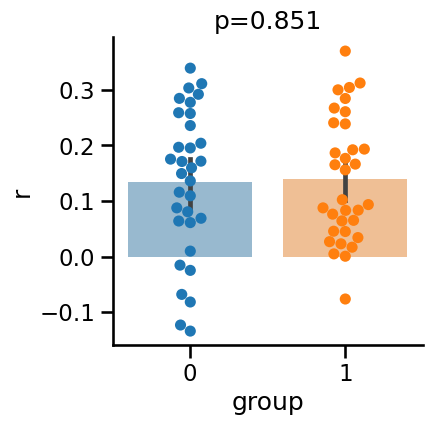

In [19]:
temp = r_12 #r_stim2

y_var = 'r'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, alpha=0.5, hue='group', legend=False)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
sns.despine()
print(len(temp))

In [21]:
rs = pd.DataFrame(r_stim2).rename(columns ={'r':'r_stim2'}).join(pd.DataFrame(r_stim1).rename(columns ={'r':'r_stim1'}))

rs['dif'] = rs['r_stim1'] - rs['r_stim2']

In [28]:
rs_ = pd.DataFrame(r_12).rename(columns ={'r':'r_pred1num2'}).join(pd.DataFrame(r_21).rename(columns ={'r':'r_pred2num1'}))

df_comb = rs.join(rs_)
df_comb.mean(axis=0)

r_stim2        0.134879
r_stim1        0.164088
dif            0.029210
r_pred1num2    0.138275
r_pred2num1    0.164088
dtype: float64

/sctmp/mrenke/ipykernel_1743183/4292669441.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_ = np.round(cor['r'][0], 2)
/sctmp/mrenke/ipykernel_1743183/4292669441.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = np.round(cor['p-val'][0], 3)


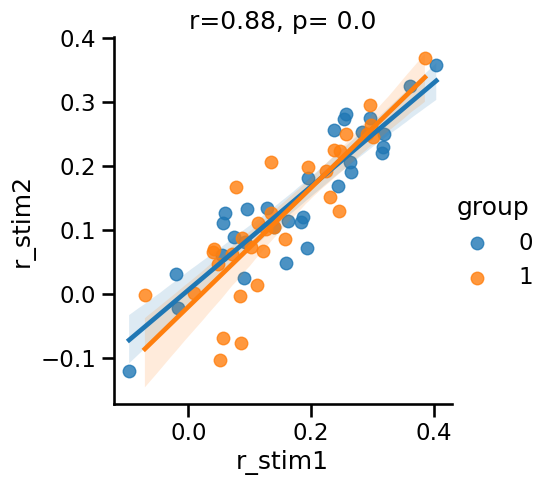

In [22]:

y_var = 'r_stim2' 
x_var = 'r_stim1' 

cor = pg.corr(df_comb[y_var], df_comb[x_var])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb.reset_index(),hue='group') # 
fig.set(title=f'r={r_}, p= {p}') 

64


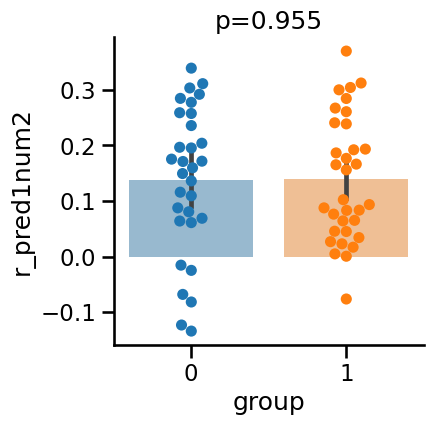

In [24]:
temp = df_comb

y_var = 'r_pred1num2'
an = pg.anova(data=temp.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)

sns.set_context('talk')
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(ax=ax,data=temp.reset_index(), x='group', y=y_var, alpha=0.5, hue='group', legend=False)
sns.swarmplot(ax=ax, data=temp.reset_index(), x='group', y=y_var,  hue='group',size=8,legend=False)
ax.set(title=f'p={p_val}') # ylim=(0.5,1),
sns.despine()
print(len(temp))

r_stim2        0.134879
r_stim1        0.164088
dif            0.029210
r_pred1num2    0.138275
r_pred2num1    0.164088
dtype: float64

## NotesWith Old bug:

decodability between stimulus 1 and 2 are very strongly correlated
if I correlate n1 with pred_n2 I get almost the same decodability
makes sense as n2 is n1*frac, they are correlated and the encoding-decoding framework just gets the overall magnitude range (defined by the base number, n1), not "fine-grained" enough


might be:

* the bluriness of the BOLD or 
* because the exact same nPRFs are recruited for stim 1 and 2 (and the decision process at time point of stim 2 does not interfere too much with it)